# Uncertainty propagation and error-models equivalence

In [1]:
%matplotlib inline
# use `widget` instead of `inline` for better user-exeperience. `inline` allows to store plots into notebooks.

In [2]:
import time
start_time = time.perf_counter()
import sys
print(sys.executable)
print(sys.version)
import os
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "0"

/home/jerome/.venv/py311/bin/python3
3.11.2 (main, Nov 30 2024, 21:22:50) [GCC 12.2.0]


In [3]:
pix = 100e-6
shape = (1024, 1024)
npt = 1000
nimg = 1000
wl = 1e-10
I0 = 1e2
kwargs = {"npt":npt,
         "correctSolidAngle":True,
         "polarization_factor":0.99,
         "safe":False,
         "error_model":"poisson",
         "method":("full", "csr", "opencl"),
         }
         # "normalization_factor": 1.0}


In [4]:
import numpy
from scipy.stats import chi2 as chi2_dist
from matplotlib.pyplot import subplots
from matplotlib.colors import LogNorm
import logging
logging.basicConfig(level=logging.ERROR)
import pyFAI
print(f"pyFAI version: {pyFAI.version}")
from pyFAI.detectors import Detector
from pyFAI.method_registry import IntegrationMethod
from pyFAI.gui import jupyter
detector = Detector(pix, pix)
detector.shape = detector.max_shape = shape
print(detector)
flat = numpy.random.random(shape)*1+1

pyFAI version: 2025.3.0
Detector Detector	 PixelSize= 100µm, 100µm	 BottomRight (3)


In [5]:
ai_init = {"dist":1.0,
           "poni1":0.0,
           "poni2":0.0,
           "rot1":-0.05,
           "rot2":+0.05,
           "rot3":0.0,
           "detector":detector,
           "wavelength":wl}
ai = pyFAI.load(ai_init)
print(ai)

Detector Detector	 PixelSize= 100µm, 100µm	 BottomRight (3)
Wavelength= 1.000000e-10 m
SampleDetDist= 1.000000e+00 m	PONI= 0.000000e+00, 0.000000e+00 m	rot1=-0.050000  rot2=0.050000  rot3=0.000000 rad
DirectBeamDist= 1002.504 mm	Center: x=500.417, y=501.043 pix	Tilt= 4.051° tiltPlanRotation= 45.036° 𝛌= 1.000Å


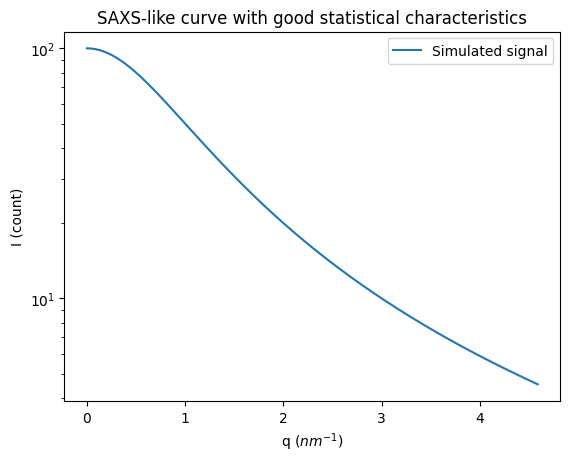

In [6]:
# Generation of a "SAXS-like" curve with the shape of a lorentzian curve
unit="q_nm^-1"
q = numpy.linspace(0, ai.array_from_unit(unit=unit).max(), npt)
I = I0/(1+q**2)
fig, ax = subplots()
ax.semilogy(q, I, label="Simulated signal")
ax.set_xlabel("q ($nm^{-1}$)")
ax.set_ylabel("I (count)")
ax.set_title("SAXS-like curve with good statistical characteristics")
ax.legend()
pass

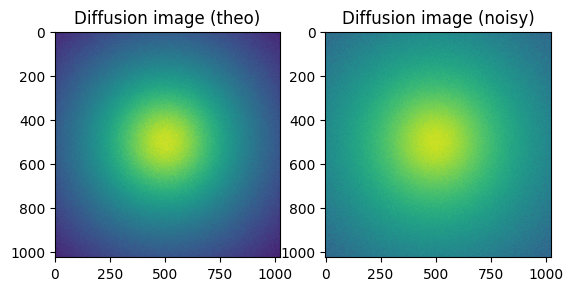

In [7]:
#Reconstruction of diffusion image:
img_theo = ai.calcfrom1d(q, I, dim1_unit="q_nm^-1",
                         correctSolidAngle=True,
                         polarization_factor=None,
                         flat=flat)
kwargs["flat"] = flat
img_poisson = numpy.random.poisson(img_theo)
fig, ax = subplots(1, 2)
ax[0].imshow(img_theo, norm=LogNorm())
_=ax[0].set_title("Diffusion image (theo)")
ax[1].imshow(img_poisson, norm=LogNorm())
_=ax[1].set_title("Diffusion image (noisy)")

## Azimuthal Integration

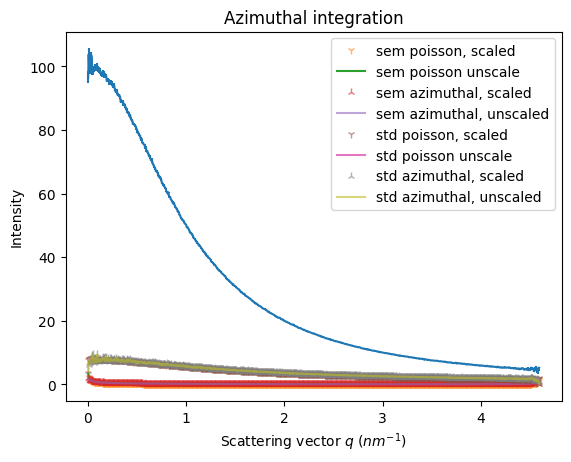

In [8]:
factor = 1e-6
alpha=0.6
k = kwargs.copy()
k["error_model"] = "azimuthal"
np = kwargs.copy()
np["method"] = ("full", "csr", "python")
npa = np.copy()
npa["error_model"] = "azimuthal"


ref = ai.integrate1d(img_poisson, **kwargs)

ref_np = ai.integrate1d(img_poisson, **np)
res_azim = ai.integrate1d(img_poisson, **k)
np_azim = ai.integrate1d(img_poisson, **npa)
res_renorm = ai.integrate1d(img_poisson, normalization_factor=factor, **kwargs)
res_azim_renorm = ai.integrate1d(img_poisson, normalization_factor=factor, **k)

ax = jupyter.plot1d(res_azim)
ax.plot(res_renorm.radial, res_renorm.sem*factor, "1",alpha=alpha,  label="sem poisson, scaled")
ax.plot(ref.radial, ref.sem, label="sem poisson unscale")
ax.plot(res_azim_renorm.radial, res_azim_renorm.sem*factor,"2", alpha=alpha, label="sem azimuthal, scaled")
ax.plot(res_azim.radial, res_azim.sem, alpha=alpha, label="sem azimuthal, unscaled")

ax.plot(res_renorm.radial, res_renorm.std*factor,"1", alpha=alpha, label="std poisson, scaled")
ax.plot(ref.radial, ref.std, label="std poisson unscale")
ax.plot(res_azim_renorm.radial, res_azim_renorm.std*factor, "2", alpha=alpha, label="std azimuthal, scaled")
ax.plot(res_azim.radial, res_azim.std, alpha=alpha,label="std azimuthal, unscaled")


ax.legend()
_=ax.set_title("Azimuthal integration")

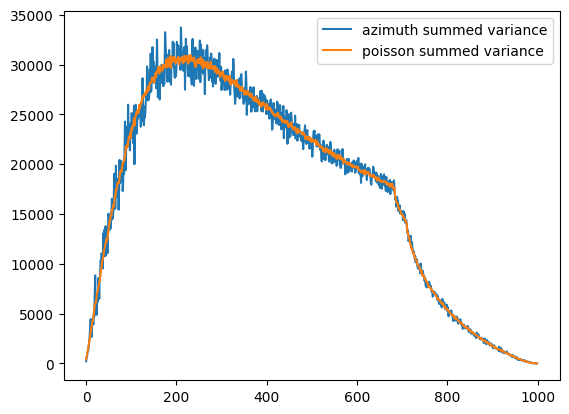

In [9]:
fig,ax = subplots()
what = "sum_variance"
ax.plot(np_azim.__getattribute__(what), label="azimuth summed variance")
ax.plot(ref_np.__getattribute__(what), label="poisson summed variance")
ax.legend()

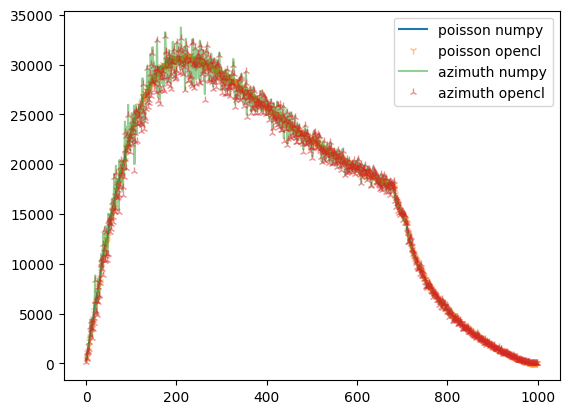

In [10]:
fig,ax = subplots()
what = "sum_variance"
ax.plot(ref_np.__getattribute__(what), label="poisson numpy")
ax.plot(ref.__getattribute__(what),"1", alpha=0.5, label="poisson opencl")
ax.plot(np_azim.__getattribute__(what), alpha=0.5, label="azimuth numpy")
ax.plot(res_azim.__getattribute__(what), "2", alpha=0.5, label="azimuth opencl")
ax.legend()

## Sigma clipping

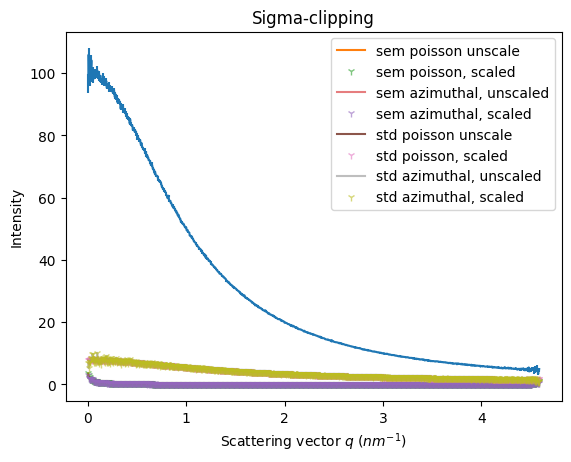

In [11]:
factor = 1e-6
kwargs["method"] = ("no", "csr", "opencl")
k = kwargs.copy()
k["error_model"] = "azimuthal"
npp = kwargs.copy()
npp["method"] = ("no", "csr", "python")
npa = npp.copy()
npa["error_model"] = "azimuthal"

res_azim = ai.sigma_clip_ng(img_poisson, **k)
res_renorm = ai.sigma_clip_ng(img_poisson, normalization_factor=factor, **kwargs)
res_azim_renorm = ai.sigma_clip_ng(img_poisson, normalization_factor=factor, **k)
ref = ai.sigma_clip_ng(img_poisson, **kwargs)
npp = ai.sigma_clip_ng(img_poisson, **npp)
npa = ai.sigma_clip_ng(img_poisson, **npa)

ax = jupyter.plot1d(res_azim)
ax.plot(ref.radial, ref.sem, label="sem poisson unscale")
ax.plot(res_renorm.radial, res_renorm.sem*factor, "1",alpha=alpha, label="sem poisson, scaled")
ax.plot(res_azim.radial, res_azim.sem, alpha=alpha, label="sem azimuthal, unscaled")
ax.plot(res_azim_renorm.radial, res_azim_renorm.sem*factor, "1",alpha=alpha, label="sem azimuthal, scaled")

ax.plot(ref.radial, ref.std, label="std poisson unscale")
ax.plot(res_renorm.radial, res_renorm.std*factor, "1",alpha=alpha, label="std poisson, scaled")
ax.plot(res_azim.radial, res_azim.std, alpha=0.5, label="std azimuthal, unscaled")
ax.plot(res_azim_renorm.radial, res_azim_renorm.std*factor, "1",alpha=alpha, label="std azimuthal, scaled")

ax.legend()
_=ax.set_title("Sigma-clipping")

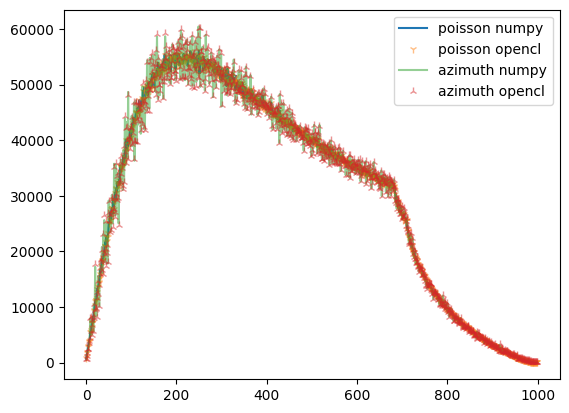

In [12]:
fig,ax = subplots()
what = "sum_variance"
ax.plot(npp.__getattribute__(what), label="poisson numpy")
ax.plot(ref.__getattribute__(what),"1",alpha=0.5, label="poisson opencl")
ax.plot(npa.__getattribute__(what), alpha=0.5, label="azimuth numpy")
ax.plot(res_azim.__getattribute__(what), "2", alpha=0.5, label="azimuth opencl")
ax.legend()

## Experimental validation of the Formula:

VV_AUB = V_A + VV_B + ΩΩ_B(V_A.Ω_B-V_B.Ω_A)²/(Ω_AUB.Ω_A.Ω_B²)

In [13]:
s = 100
l = 90
P = numpy.random.poisson(100, s)
P.sort()
w = numpy.random.random(s)+1

A = P[:l]
wA = w[:l]
B = P[l:]
wB = w[l:]

class Partition:
    def __init__(self, x, w=None):
        self.x = x
        self.w = w if w is not None else numpy.ones_like(x)
    @property
    def Omega(self):
        return self.w.sum()

    @property
    def Omega2(self):
        return (self.w*self.w).sum()

    @property
    def V(self):
        return (self.x*self.w).sum()
    @property
    def mean(self):
        return self.V/self.Omega
    @property
    def VV(self):
        return (self.w**2*(self.x - self.mean)**2).sum()
    
A = Partition(A, wA)
B = Partition(B, wB)
P = Partition(P, w)
P.VV, A.VV, B.VV, A.VV + B.VV

(np.float64(19440.671635759394),
 np.float64(12126.8623975731),
 np.float64(205.43852726633702),
 np.float64(12332.300924839437))

In [14]:
# This is the delta we are looking for:
D = P.VV - A.VV - B.VV
D

np.float64(7108.370710919957)

In [15]:
# Naive translation of the formula:
%timeit (B.mean - A.mean)*(B.mean-P.mean)*B.Omega2
(B.mean - A.mean)*(B.mean-P.mean)*B.Omega2

18.8 μs ± 452 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


np.float64(6750.455477876327)

In [16]:
# reformulation
%timeit B.Omega2*(A.Omega*B.V-B.Omega*A.V)**2/(B.Omega**2*A.Omega*P.Omega)
B.Omega2*(A.Omega*B.V-B.Omega*A.V)**2/(B.Omega**2*A.Omega*P.Omega)

15.1 μs ± 1.36 μs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


np.float64(6750.455477876313)

In [17]:
#Symmetric version not as good since Ω_A>Ω_B
%timeit A.Omega2*(A.Omega*B.V-B.Omega*A.V)**2/(A.Omega**2*B.Omega*P.Omega)
A.Omega2*(A.Omega*B.V-B.Omega*A.V)**2/(A.Omega**2*B.Omega*P.Omega)

14.4 μs ± 359 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


np.float64(7155.452610366312)